In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

sns.set(style="ticks", color_codes=True)


In [2]:
# useful for plotting 
# from https://stackoverflow.com/questions/34255242/seaborn-pairplot-pearsons-p-statistic
# adapted to discard the infinite values from log10 transformation
def corrfunc(x, y, **kws):
    if all(x==y):
        return
    df = pd.DataFrame(columns = ['x', 'y'])
    df['x'] = x
    df['y'] = y
    df=df[np.isfinite(df).all(1)]
    (r, p) = pearsonr(df['x'], df['y'])
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

# Prepare the data

In [3]:
# input data
agg_file = "GM12878_chr21_final_agg_fltrd.txt"
agg_dt = pd.read_csv(agg_file, sep="\t")
agg_dt.head()

,binScore,ENCFF001SUB_ENCFF001XPJ_ENCFF001XPK_CTCF,ENCFF001SUC_EZH2,ENCFF001SUD_H2AFZ,ENCFF001SUE_H3K4me1,ENCFF001SUF_ENCFF001SUM_ENCFF001WYJ_ENCFF001WYK_H3K4me3,ENCFF001SUG_H3K27ac,ENCFF001SUI_ENCFF001WYB_ENCFF001WYE_H3K27me3,ENCFF001SUJ_ENCFF001WYF_ENCFF001WYH_H3K36me3,ENCFF001SUL_H3K4me2,...,ENCFF001TYY_ENCFF001TYZ_SP1,ENCFF001TZA_ENCFF001TZB_ENCFF001TZC_ENCFF001TZD_SRF,ENCFF001TZE_ENCFF001TZF_STAT5A,ENCFF001TZG_ENCFF001TZH_TAF1,ENCFF001TZI_ENCFF001TZJ_TCF12,ENCFF001TZK_ENCFF001TZL_TCF3,ENCFF001TZM_ENCFF001TZN_USF1,ENCFF001TZO_ENCFF001TZP_YY1,ENCFF001TZQ_ENCFF001TZR_ZBTB33,ENCFF001TZS_ENCFF001TZT_ZEB1
0,0.274411,214.440683,66.442082,23.843815,22.832315,284.105463,26.1137,262.380565,267.083390,25.012752,...,1515.33,6200.0,3119.58,6200.0,6200.00,6200.00,0.0,4340.56,4360.67,6200.0
1,0.034241,46.493788,0.000000,1.614630,0.000000,95.168904,0.0000,45.287057,76.900823,0.000000,...,293.81,0.0,0.00,0.0,789.65,280.41,0.0,0.00,676.40,0.0
2,0.013394,44.122768,3.624789,1.614630,11.022849,103.963208,0.0000,60.192740,107.731141,0.000000,...,949.34,0.0,0.00,0.0,381.39,1953.56,0.0,0.00,3041.46,0.0
3,0.104079,59.999873,2.820925,1.614630,2.124582,88.244054,0.0000,27.252910,50.435950,0.000000,...,941.84,0.0,0.00,0.0,958.82,673.77,0.0,0.00,926.44,0.0
4,0.365481,166.417762,12.308130,1.614630,2.124582,66.145094,0.0000,75.265690,164.082678,1.909962,...,0.00,0.0,0.00,0.0,0.00,101.49,0.0,0.00,0.00,0.0


In [4]:
# rename the columns to avoid to have the accession name 
initCols = agg_dt.columns
col1 = initCols[1]
p = re.compile("EN.+_(.+)")
p.sub('\\1',col1)
newCols = [p.sub('\\1',x) for x in initCols]
newCols[0] = "boundaryScore"
agg_dt.columns=newCols
agg_dt.head()
agg_dt.shape

'CTCF'

,boundaryScore,CTCF,EZH2,H2AFZ,H3K4me1,H3K4me3,H3K27ac,H3K27me3,H3K36me3,H3K4me2,...,SP1,SRF,STAT5A,TAF1,TCF12,TCF3,USF1,YY1,ZBTB33,ZEB1
0,0.274411,214.440683,66.442082,23.843815,22.832315,284.105463,26.1137,262.380565,267.083390,25.012752,...,1515.33,6200.0,3119.58,6200.0,6200.00,6200.00,0.0,4340.56,4360.67,6200.0
1,0.034241,46.493788,0.000000,1.614630,0.000000,95.168904,0.0000,45.287057,76.900823,0.000000,...,293.81,0.0,0.00,0.0,789.65,280.41,0.0,0.00,676.40,0.0
2,0.013394,44.122768,3.624789,1.614630,11.022849,103.963208,0.0000,60.192740,107.731141,0.000000,...,949.34,0.0,0.00,0.0,381.39,1953.56,0.0,0.00,3041.46,0.0
3,0.104079,59.999873,2.820925,1.614630,2.124582,88.244054,0.0000,27.252910,50.435950,0.000000,...,941.84,0.0,0.00,0.0,958.82,673.77,0.0,0.00,926.44,0.0
4,0.365481,166.417762,12.308130,1.614630,2.124582,66.145094,0.0000,75.265690,164.082678,1.909962,...,0.00,0.0,0.00,0.0,0.00,101.49,0.0,0.00,0.00,0.0


(1662, 57)

In [5]:
# keep 3 marks as examples
markCols = ['CTCF', 'H2AFZ', 'H3K4me1']
keepCols = ['boundaryScore'] + markCols
keep_dt = agg_dt[keepCols]
# keep_dt.head()

In [6]:
# same data, but remove the zero values
# the binScore is never 0
sum(keep_dt['boundaryScore'] == 0)

# discard rows that have all 0
keep_dt_noAll0 = keep_dt[(keep_dt[markCols].sum(axis=1) != 0)]

# discard rows that have all 0
# delete if any 0
keep_dt_noAny0 = keep_dt[(keep_dt[markCols] != 0).all(1)]

keep_dt.shape
# (1662, 4)
keep_dt_noAll0.shape
# (1219, 4)
keep_dt_noAny0.shape
# (275, 4)

# => will go futher with noAll0
keep_dt_noAll0_log10 = keep_dt_noAll0.copy()
keep_dt_noAll0_log10[markCols] = np.log10(keep_dt_noAll0_log10[markCols])
# keep_dt_noAll0.head()
# keep_dt_noAll0_log10.head()
newNames = keep_dt_noAll0_log10.columns
newNames2 = ['boundaryScore'] + [x + " [log10]" for x in list(newNames)[1:]]
keep_dt_noAll0_log10.columns = newNames2
# = ['a','b','c']# keep_dt_noAll0_log10.columns[1:] + " [log10]" 

# data in long format
# reshape the data
m_keep_dt = pd.melt(keep_dt, id_vars=['boundaryScore'], value_vars=keepCols[1:])
# m_keep_dt.head()
m_keep_dt.shape
# (4986, 3)
# data frame with no zeros:
m_keep_dt_no0 = m_keep_dt[m_keep_dt['value'] > 0]
# m_keep_dt_no0.head()
m_keep_dt_no0.shape
# (2169, 3)
m_keep_dt_no0_log10 = m_keep_dt_no0.copy()
m_keep_dt_no0_log10['value'] = np.log10(m_keep_dt_no0_log10['value'])

m_keep_dt_withBs = pd.melt(keep_dt)
m_keep_dt_withBs.head()

#min(m_keep_dt_no0['value']) # 1.17
logOffset = 0.01
m_keep_dt_withOffset_log10 = m_keep_dt.copy()
m_keep_dt_withOffset_log10['value'] = m_keep_dt_withOffset_log10['value'] + logOffset
m_keep_dt_withOffset_log10['value'] = np.log10(m_keep_dt_withOffset_log10['value'])

min(m_keep_dt_no0['value'])

0

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


(1662, 4)

(1357, 4)

(566, 4)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


(4986, 3)

(2845, 3)

,variable,value
0,boundaryScore,0.274411
1,boundaryScore,0.034241
2,boundaryScore,0.013394
3,boundaryScore,0.104079
4,boundaryScore,0.365481


1.168807

# Some exploratory analyses and descriptive plots

## Distribution all raw variables

/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:317: UserWarning: `gridspec_kws` ignored when using `col_wrap`
  warnings.warn("`gridspec_kws` ignored when using `col_wrap`")
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 181.39999999999998, 'boundary score')

Text(0.5, 181.39999999999998, 'signal value')

Text(0.5, 6.79999999999994, 'signal value')

Text(0.5, 6.79999999999994, 'signal value')

Text(6.799999999999997, 0.5, 'density')

Text(354.4000000000001, 0.5, 'density')

Text(-7.200000000000003, 0.5, 'density')

Text(354.4000000000001, 0.5, 'density')

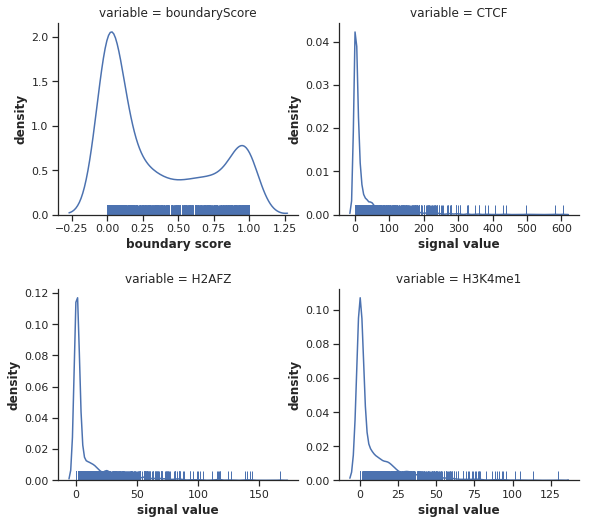

In [7]:
# ordered_days = tips.day.value_counts().index



g = sns.FacetGrid(m_keep_dt_withBs, 
                  #row="variable",# row_order=ordered_days,
                  height=2.5, 
                  col_wrap=2, col="variable",
                  aspect=2,
                  gridspec_kws={"hspace":1.1},
                  sharex=False, sharey=False)
g.map(sns.distplot, "value", hist=False, rug=True);
fontsize = 12
fontweight = 'bold'
fontproperties = {'family':'sans-serif','weight' : fontweight, 'size' : fontsize}
    
g.axes[0].set_xlabel('boundary score', fontproperties)
g.axes[1].set_xlabel('signal value', fontproperties)
g.axes[2].set_xlabel('signal value', fontproperties)
g.axes[3].set_xlabel('signal value', fontproperties)
g.axes[0].set_ylabel('density', fontproperties)
g.axes[1].set_ylabel('density', fontproperties)
g.axes[2].set_ylabel('density', fontproperties)
g.axes[3].set_ylabel('density', fontproperties)


g.fig.set_figwidth(8)
g.fig.set_figheight(8)

g.savefig('raw_data_withBs_dist.png')

#     Height (in inches) of each facet. See also: aspect.
#         Aspect ratio of each facet, so that aspect * height gives the width of each facet in inches.

## Number of zero values

<BarContainer object of 56 artists>

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0, 0.5, '# of bins')

Text(0.5, 1.0, 'Number of bins with a value of zero')

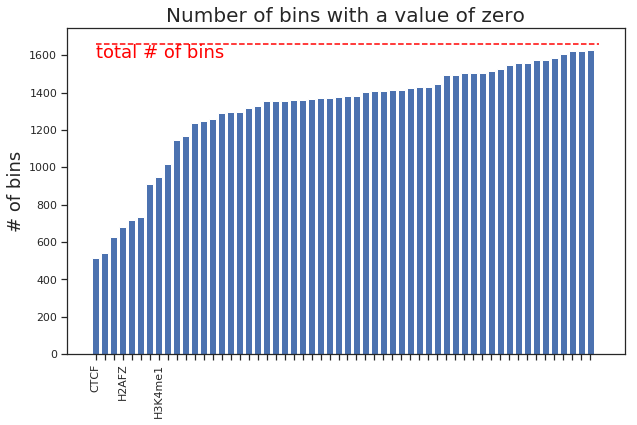

In [8]:
tmp_agg_dt = agg_dt[agg_dt.columns.difference(['boundaryScore'])]

nbr0_dt = (tmp_agg_dt == 0).astype(int).sum(axis=0)
nbr0_dt = nbr0_dt.sort_values()
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))

plt.bar(range(len(nbr0_dt.values)), nbr0_dt.values)
xlabs = [x if x in keepCols else "" for x in nbr0_dt.index]
foo = plt.xticks(range(len(xlabs)), xlabs, rotation=90) 
plt.hlines(y = agg_dt.shape[0], xmin = 0, xmax = len(xlabs), color = 'red', linestyle = 'dashed')
ax = plt.axes()
ax.set_ylabel('# of bins', size=18)
ax.set_title('Number of bins with a value of zero', size=20)

t = ax.text(0, agg_dt.shape[0]-1, "total # of bins", ha="left", va="top", size=18, color="red")

outFile = "nbrZeros_barplot.png"
plt.savefig(outFile, bbox_inches = 'tight')# pad_inches = 0)

## Distribution all predictor variables (transformed)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5, 0, 'signal value')

Text(0.5, 0, 'signal value')

Text(0.5, 0, 'signal value')

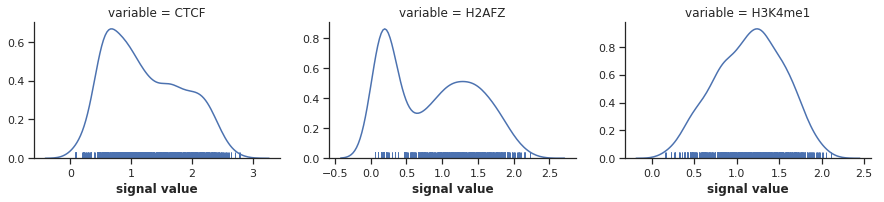

In [9]:
# ordered_days = tips.day.value_counts().index
g = sns.FacetGrid(m_keep_dt_no0_log10, col="variable",# row_order=ordered_days,
                  height=2.5, 
                  aspect=2,
                  gridspec_kws={"hspace":1.1},
                  sharex=False, sharey=False)
g.map(sns.distplot, "value", hist=False, rug=True);
fontsize = 12
fontweight = 'bold'
fontproperties = {'family':'sans-serif','weight' : fontweight, 'size' : fontsize}
    
g.axes[0,0].set_xlabel('signal value', fontproperties)
g.axes[0,1].set_xlabel('signal value', fontproperties)
g.axes[0,2].set_xlabel('signal value', fontproperties)
g.savefig('raw_data_no0_log10_dist.png')

#     Height (in inches) of each facet. See also: aspect.
#         Aspect ratio of each facet, so that aspect * height gives the width of each facet in inches.

## Pairwise correlations

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


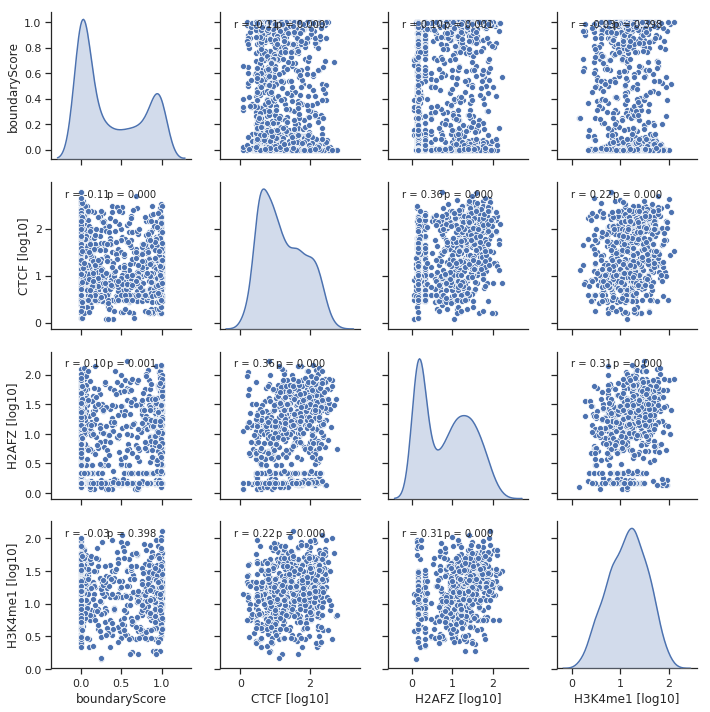

In [10]:
# sns.pairplot(keep_dt_noAny0,diag_kind = "kde")
graph = sns.pairplot(keep_dt_noAll0_log10, diag_kind="kde")
graph.map(corrfunc)
graph.savefig('pairwisegrid_noAll0_log10.png')

## Simple linear regression 

--- For the epignetic mark: CTCF
Intercept:	0.46
Slope:	-0.07
Mean Absolute Error:	0.35
Mean Squared Error:	0.15
Root Mean Squared Error:	0.39
Coefficient of determination:	0.01




Text(0.5, 1.0, 'tit')

Text(0.5, 0, 'CTCF')

Text(0, 0.5, 'boundary score')

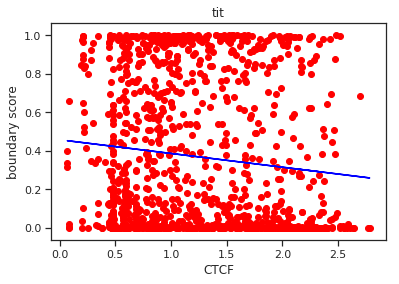

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          boundaryScore   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     14.86
Date:                Sun, 17 May 2020   Prob (F-statistic):           0.000122
Time:                        22:00:36   Log-Likelihood:                -542.81
No. Observations:                1147   AIC:                             1090.
Df Residuals:                    1145   BIC:                             1100.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4576      0.025     17.997      0.000       0.408       0.507
x1            -0.0713      0.019     -3.855      0.000      -0.108      -0.035
==============================================================================
Omnibus:                    27861.044   Durbin-Watson:                   0.551
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.440
Skew:                           0.533   Prob(JB):                     1.17e-31
Kurtosis:                       1.642   Cond. No.                         4.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.01, 1, '                            OLS Regression Results                            \n==============================================================================\nDep. Variable:          boundaryScore   R-squared:                       0.013\nModel:                            OLS   Adj. R-squared:                  0.012\nMethod:                 Least Squares   F-statistic:                     14.86\nDate:                Sun, 17 May 2020   Prob (F-statistic):           0.000122\nTime:                        22:00:36   Log-Likelihood:                -542.81\nNo. Observations:                1147   AIC:                             1090.\nDf Residuals:                    1145   BIC:                             1100.\nDf Model:                           1                                         \nCovariance Type:            nonrobust                                         \n==============================================================================\n                 coef    

(0.0, 1.0, 0.0, 1.0)

--- For the epignetic mark: H2AFZ
Intercept:	0.33
Slope:	0.07
Mean Absolute Error:	0.36
Mean Squared Error:	0.16
Root Mean Squared Error:	0.40
Coefficient of determination:	0.01




Text(0.5, 1.0, 'tit')

Text(0.5, 39.5, 'H2AFZ')

Text(77.125, 0.5, 'boundary score')

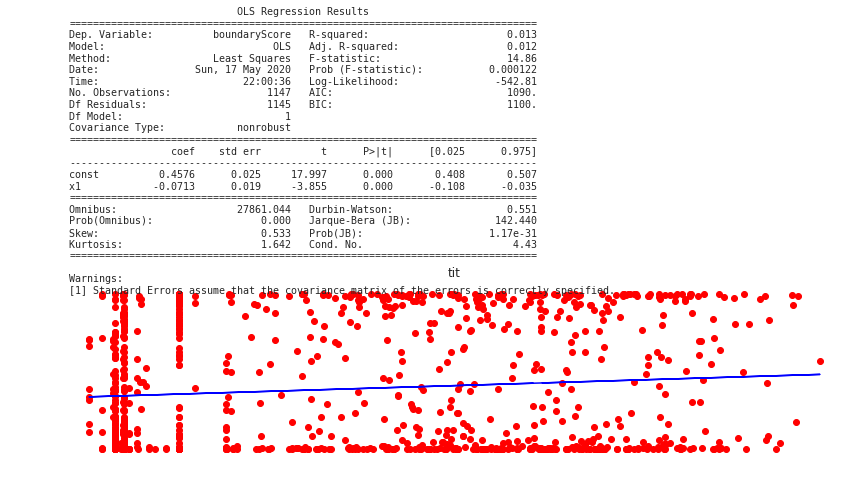

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          boundaryScore   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     10.46
Date:                Sun, 17 May 2020   Prob (F-statistic):            0.00126
Time:                        22:00:37   Log-Likelihood:                -482.60
No. Observations:                 982   AIC:                             969.2
Df Residuals:                     980   BIC:                             979.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3304      0.022     15.164      0.000       0.288       0.373
x1             0.0673      0.021      3.234      0.001       0.026       0.108
==============================================================================
Omnibus:                       24.528   Durbin-Watson:                   0.587
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.067
Skew:                           0.398   Prob(JB):                     1.40e-26
Kurtosis:                       1.491   Cond. No.                         3.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.01, 1, '                            OLS Regression Results                            \n==============================================================================\nDep. Variable:          boundaryScore   R-squared:                       0.011\nModel:                            OLS   Adj. R-squared:                  0.010\nMethod:                 Least Squares   F-statistic:                     10.46\nDate:                Sun, 17 May 2020   Prob (F-statistic):            0.00126\nTime:                        22:00:37   Log-Likelihood:                -482.60\nNo. Observations:                 982   AIC:                             969.2\nDf Residuals:                     980   BIC:                             979.0\nDf Model:                           1                                         \nCovariance Type:            nonrobust                                         \n==============================================================================\n                 coef    

(0.0, 1.0, 0.0, 1.0)

--- For the epignetic mark: H3K4me1
Intercept:	0.48
Slope:	-0.03
Mean Absolute Error:	0.39
Mean Squared Error:	0.17
Root Mean Squared Error:	0.41
Coefficient of determination:	0.00




Text(0.5, 1.0, 'tit')

Text(0.5, 39.5, 'H3K4me1')

Text(77.125, 0.5, 'boundary score')

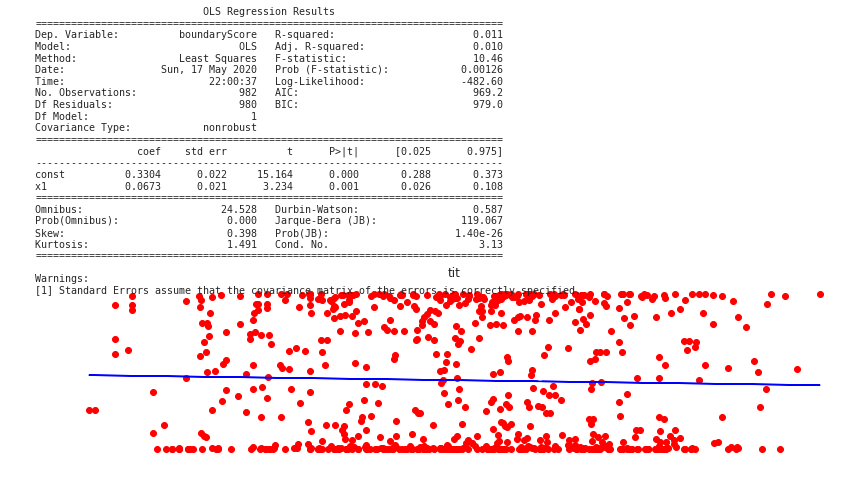

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          boundaryScore   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7147
Date:                Sun, 17 May 2020   Prob (F-statistic):              0.398
Time:                        22:00:38   Log-Likelihood:                -381.71
No. Observations:                 716   AIC:                             767.4
Df Residuals:                     714   BIC:                             776.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4800      0.048     10.081      0.000       0.387       0.574
x1            -0.0330      0.039     -0.845      0.398      -0.110       0.044
==============================================================================
Omnibus:                        4.189   Durbin-Watson:                   0.728
Prob(Omnibus):                  0.123   Jarque-Bera (JB):               90.440
Skew:                           0.187   Prob(JB):                     2.30e-20
Kurtosis:                       1.300   Cond. No.                         6.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.01, 1, '                            OLS Regression Results                            \n==============================================================================\nDep. Variable:          boundaryScore   R-squared:                       0.001\nModel:                            OLS   Adj. R-squared:                 -0.000\nMethod:                 Least Squares   F-statistic:                    0.7147\nDate:                Sun, 17 May 2020   Prob (F-statistic):              0.398\nTime:                        22:00:38   Log-Likelihood:                -381.71\nNo. Observations:                 716   AIC:                             767.4\nDf Residuals:                     714   BIC:                             776.6\nDf Model:                           1                                         \nCovariance Type:            nonrobust                                         \n==============================================================================\n                 coef    

(0.0, 1.0, 0.0, 1.0)

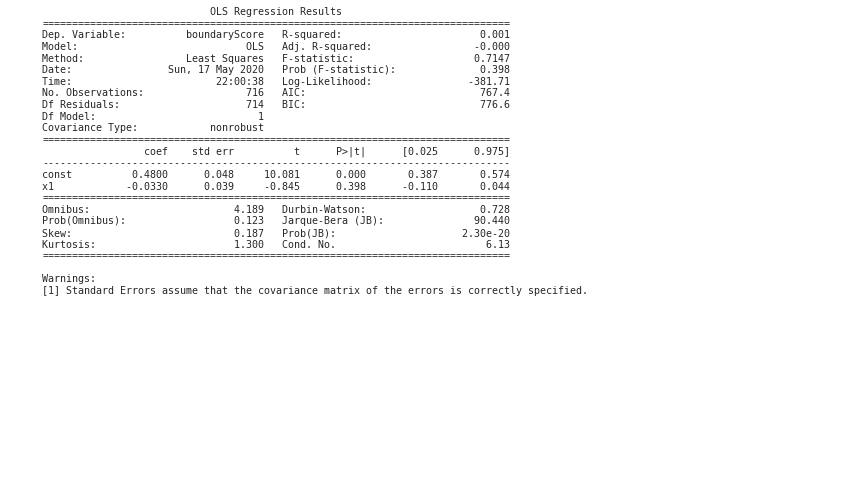

In [12]:
# some basic linear regressions
from sklearn.linear_model import LinearRegression
from sklearn import metrics


for mark in markCols:
    
    print("--- For the epignetic mark: " + mark )
    
    tmp_dt = keep_dt[['boundaryScore', mark]]
    tmp_dt = tmp_dt[tmp_dt[mark] > 0]
    tmp_dt[mark] = np.log10(tmp_dt[mark])
    my_y = tmp_dt['boundaryScore']
    my_x = tmp_dt[mark].values.reshape(-1,1)
    
    regressor = LinearRegression()  
#     my_y = keep_dt_noAll0_log10['boundaryScore'] # reshape to (1147,1) array (should be 2D)
#     my_x = keep_dt_noAll0_log10[mark_lab].values.reshape(-1,1) # (1147,)
    foo=regressor.fit(my_x, my_y) #training the algorithm
    
    y_pred = regressor.predict(my_x)
    #To retrieve the intercept:
    print('Intercept:\t%.2f' % regressor.intercept_)
    # The coefficients
    print('Slope:\t%.2f' % regressor.coef_)
    print('Mean Absolute Error:\t%.2f' % metrics.mean_absolute_error(my_y, y_pred))  
    print('Mean Squared Error:\t%.2f' % metrics.mean_squared_error(my_y, y_pred))  
    print('Root Mean Squared Error:\t%.2f' % np.sqrt(metrics.mean_squared_error(my_y, y_pred)))
    print('Coefficient of determination:\t%.2f' % metrics.r2_score(my_y, y_pred))  
    print("\n")
    
    plt.scatter(my_x, my_y, color = 'red')
    plt.plot(my_x, y_pred, color = 'blue')
    plt.title('tit')
    plt.xlabel(mark)
    plt.ylabel('boundary score')
    plt.show()

    
    # model0 = sm.OLS(my_y, my_x).fit()
    # model0.summary() # model without intercept

    my_x2 = sm.add_constant(my_x.ravel())
    model = sm.OLS(my_y, my_x2, missing='drop').fit() ## sm.OLS(output, input)

    model.summary()

    
    plt.rc('figure', figsize=(12, 7))
    #plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
#     plt.text(0.01, 0.05, str("--- Predictive variable: " + mark+"\n"), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
#     plt.text(0.01, 1, str(model.summary(xname=["const.", mark])), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!

    plt.text(0.01, 1, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.axis('off')
    plt.tight_layout()
    outFile = mark+'model_summary.png'
    plt.savefig(outFile)





## Multiple linear regression

array([0.41722828])

array([[-0.03765632, -0.00261459,  0.05659899]])

Mean Absolute Error:	0.34
Mean Squared Error:	0.14
Root Mean Squared Error:	0.38
Coefficient of determination:	0.05




/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     23.24
Date:                Sun, 17 May 2020   Prob (F-statistic):           1.14e-14
Time:                        22:01:08   Log-Likelihood:                -604.13
No. Observations:                1357   AIC:                             1216.
Df Residuals:                    1353   BIC:                             1237.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4172      0.013     32.709      0.000       0.392       0.442
CTCF [log10]       -0.0377      0.008     -4.480      0.000      -0.054      -0.021
H2AFZ [log10]      -0.0026      0.009     -0.296      0.768      -0.020       0.015
H3K4me1 [log10]     0.0566      0.008      7.071      0.000       0.041       0.072
==============================================================================
Omnibus:                     2006.057   Durbin-Watson:                   0.542
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.174
Skew:                           0.460   Prob(JB):                     9.91e-31
Kurtosis:                       1.736   Cond. No.                         2.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.01, 0.05, '                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                      y   R-squared:                       0.049\nModel:                            OLS   Adj. R-squared:                  0.047\nMethod:                 Least Squares   F-statistic:                     23.24\nDate:                Sun, 17 May 2020   Prob (F-statistic):           1.14e-14\nTime:                        22:01:08   Log-Likelihood:                -604.13\nNo. Observations:                1357   AIC:                             1216.\nDf Residuals:                    1353   BIC:                             1237.\nDf Model:                           3                                         \nCovariance Type:            nonrobust                                         \n===================================================================================\n                 

(0.0, 1.0, 0.0, 1.0)

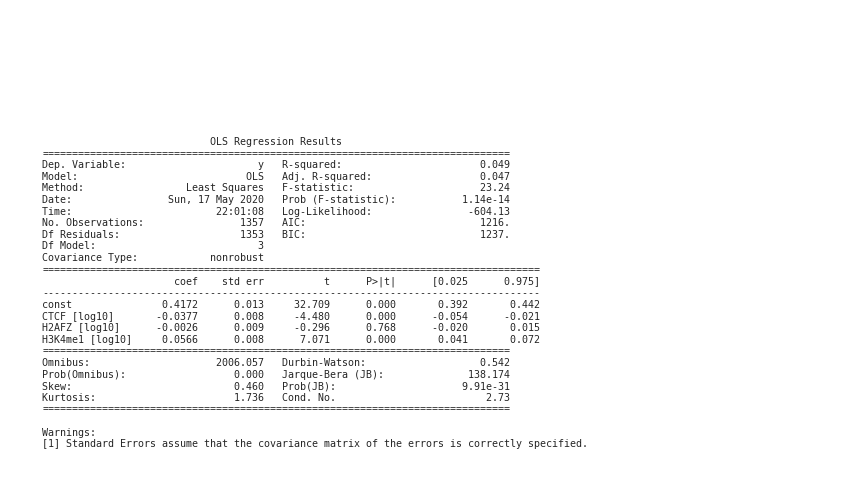

In [14]:

regressor = LinearRegression()

markCols_lab = [x+ " [log10]" for x in markCols]

tmp_dt = keep_dt_noAll0_log10.copy()
tmp_dt.replace([np.inf, -np.inf], np.log10(logOffset), inplace=True)
my_y = tmp_dt['boundaryScore'].values.reshape(-1,1) # reshape to (1147,1) array (should be 2D)
my_x = tmp_dt[markCols_lab] # (1147,)
foo=regressor.fit(my_x, my_y) #training the algorithm

y_pred = regressor.predict(my_x)
#To retrieve the intercept:
# print('Intercept:\t%.2f' % 
regressor.intercept_
# # The coefficients
# print('Slope:\t%.2f' % 
regressor.coef_
print('Mean Absolute Error:\t%.2f' % metrics.mean_absolute_error(my_y, y_pred))
print('Mean Squared Error:\t%.2f' % metrics.mean_squared_error(my_y, y_pred))
print('Root Mean Squared Error:\t%.2f' % np.sqrt(metrics.mean_squared_error(my_y, y_pred)))
print('Coefficient of determination:\t%.2f' % metrics.r2_score(my_y, y_pred))
print("\n")

my_x2 = sm.add_constant(my_x)
multi_model = sm.OLS(my_y, my_x2).fit()
multi_model.summary()

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(multi_model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
outFile = 'multivariate_model_summary.png'
plt.savefig(outFile)

    

array([0.38589847])

array([[-0.00012159,  0.04524242]])

Mean Absolute Error:	0.34
Mean Squared Error:	0.14
Root Mean Squared Error:	0.38
Coefficient of determination:	0.03




/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     24.48
Date:                Sun, 17 May 2020   Prob (F-statistic):           3.60e-11
Time:                        22:01:14   Log-Likelihood:                -614.12
No. Observations:                1357   AIC:                             1234.
Df Residuals:                    1354   BIC:                             1250.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3859      0.011     35.924      0.000       0.365       0.407
H2AFZ [log10]      -0.0001      0.009     -0.014      0.989      -0.018       0.017
H3K4me1 [log10]     0.0452      0.008      5.917      0.000       0.030       0.060
==============================================================================
Omnibus:                     8599.264   Durbin-Watson:                   0.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.908
Skew:                           0.441   Prob(JB):                     3.42e-32
Kurtosis:                       1.664   Cond. No.                         2.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.01, 0.05, '                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                      y   R-squared:                       0.035\nModel:                            OLS   Adj. R-squared:                  0.033\nMethod:                 Least Squares   F-statistic:                     24.48\nDate:                Sun, 17 May 2020   Prob (F-statistic):           3.60e-11\nTime:                        22:01:14   Log-Likelihood:                -614.12\nNo. Observations:                1357   AIC:                             1234.\nDf Residuals:                    1354   BIC:                             1250.\nDf Model:                           2                                         \nCovariance Type:            nonrobust                                         \n===================================================================================\n                 

(0.0, 1.0, 0.0, 1.0)

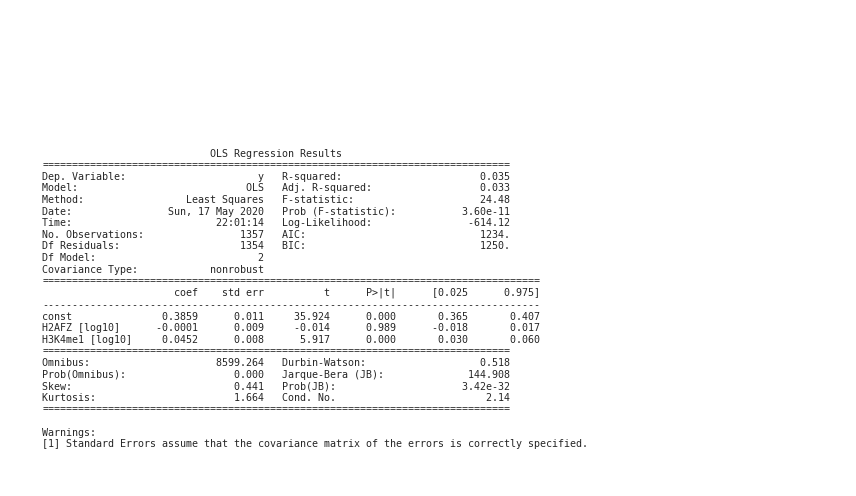

In [15]:

regressor = LinearRegression()

markCols_lab = [x+ " [log10]" for x in ['H2AFZ', 'H3K4me1']]

tmp_dt = keep_dt_noAll0_log10.copy()
tmp_dt.replace([np.inf, -np.inf], np.log10(logOffset), inplace=True)
my_y = tmp_dt['boundaryScore'].values.reshape(-1,1) # reshape to (1147,1) array (should be 2D)
my_x = tmp_dt[markCols_lab] # (1147,)
foo=regressor.fit(my_x, my_y) #training the algorithm

y_pred = regressor.predict(my_x)
#To retrieve the intercept:
# print('Intercept:\t%.2f' % 
regressor.intercept_
# # The coefficients
# print('Slope:\t%.2f' % 
regressor.coef_
print('Mean Absolute Error:\t%.2f' % metrics.mean_absolute_error(my_y, y_pred))
print('Mean Squared Error:\t%.2f' % metrics.mean_squared_error(my_y, y_pred))
print('Root Mean Squared Error:\t%.2f' % np.sqrt(metrics.mean_squared_error(my_y, y_pred)))
print('Coefficient of determination:\t%.2f' % metrics.r2_score(my_y, y_pred))
print("\n")

my_x2 = sm.add_constant(my_x)
multi_model = sm.OLS(my_y, my_x2).fit()
multi_model.summary()

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(multi_model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
outFile = 'multivariate2_model_summary.png'
plt.savefig(outFile)

    

array([0.38243531])

array([[ 0.03034065, -0.01883223]])

Mean Absolute Error:	0.35
Mean Squared Error:	0.15
Root Mean Squared Error:	0.38
Coefficient of determination:	0.01




/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     9.518
Date:                Sun, 17 May 2020   Prob (F-statistic):           7.86e-05
Time:                        22:01:18   Log-Likelihood:                -628.75
No. Observations:                1357   AIC:                             1264.
Df Residuals:                    1354   BIC:                             1279.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3824      0.012     31.925      0.000       0.359       0.406
H2AFZ [log10]     0.0303      0.008      3.963      0.000       0.015       0.045
CTCF [log10]     -0.0188      0.008     -2.320      0.020      -0.035      -0.003
==============================================================================
Omnibus:                       50.258   Durbin-Watson:                   0.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.591
Skew:                           0.495   Prob(JB):                     4.94e-36
Kurtosis:                       1.623   Cond. No.                         2.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.01, 0.05, '                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                      y   R-squared:                       0.014\nModel:                            OLS   Adj. R-squared:                  0.012\nMethod:                 Least Squares   F-statistic:                     9.518\nDate:                Sun, 17 May 2020   Prob (F-statistic):           7.86e-05\nTime:                        22:01:18   Log-Likelihood:                -628.75\nNo. Observations:                1357   AIC:                             1264.\nDf Residuals:                    1354   BIC:                             1279.\nDf Model:                           2                                         \nCovariance Type:            nonrobust                                         \n=================================================================================\n                   

(0.0, 1.0, 0.0, 1.0)

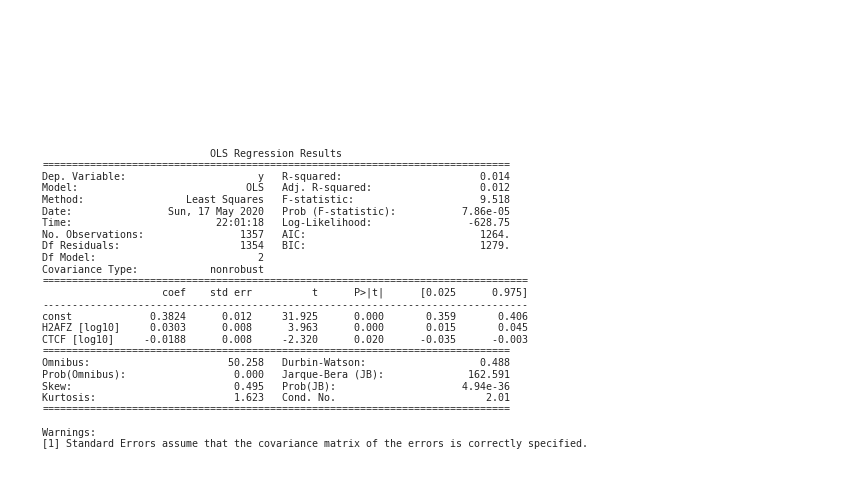

In [16]:

regressor = LinearRegression()

markCols_lab = [x+ " [log10]" for x in ['H2AFZ', 'CTCF']]

tmp_dt = keep_dt_noAll0_log10.copy()
tmp_dt.replace([np.inf, -np.inf], np.log10(logOffset), inplace=True)
my_y = tmp_dt['boundaryScore'].values.reshape(-1,1) # reshape to (1147,1) array (should be 2D)
my_x = tmp_dt[markCols_lab] # (1147,)
foo=regressor.fit(my_x, my_y) #training the algorithm

y_pred = regressor.predict(my_x)
#To retrieve the intercept:
# print('Intercept:\t%.2f' % 
regressor.intercept_
# # The coefficients
# print('Slope:\t%.2f' % 
regressor.coef_
print('Mean Absolute Error:\t%.2f' % metrics.mean_absolute_error(my_y, y_pred))
print('Mean Squared Error:\t%.2f' % metrics.mean_squared_error(my_y, y_pred))
print('Root Mean Squared Error:\t%.2f' % np.sqrt(metrics.mean_squared_error(my_y, y_pred)))
print('Coefficient of determination:\t%.2f' % metrics.r2_score(my_y, y_pred))
print("\n")

my_x2 = sm.add_constant(my_x)
multi_model = sm.OLS(my_y, my_x2).fit()
multi_model.summary()

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(multi_model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
outFile = 'multivariate3_model_summary.png'
plt.savefig(outFile)

    

array([0.41652735])

array([[ 0.05535293, -0.03750008]])

Mean Absolute Error:	0.34
Mean Squared Error:	0.14
Root Mean Squared Error:	0.38
Coefficient of determination:	0.05




/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     34.84
Date:                Sun, 17 May 2020   Prob (F-statistic):           1.76e-15
Time:                        22:01:23   Log-Likelihood:                -604.18
No. Observations:                1357   AIC:                             1214.
Df Residuals:                    1354   BIC:                             1230.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4165      0.013     33.245      0.000       0.392       0.441
H3K4me1 [log10]     0.0554      0.007      8.138      0.000       0.042       0.069
CTCF [log10]       -0.0375      0.008     -4.471      0.000      -0.054      -0.021
==============================================================================
Omnibus:                     2076.664   Durbin-Watson:                   0.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.198
Skew:                           0.458   Prob(JB):                     9.79e-31
Kurtosis:                       1.733   Cond. No.                         2.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.01, 0.05, '                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                      y   R-squared:                       0.049\nModel:                            OLS   Adj. R-squared:                  0.048\nMethod:                 Least Squares   F-statistic:                     34.84\nDate:                Sun, 17 May 2020   Prob (F-statistic):           1.76e-15\nTime:                        22:01:23   Log-Likelihood:                -604.18\nNo. Observations:                1357   AIC:                             1214.\nDf Residuals:                    1354   BIC:                             1230.\nDf Model:                           2                                         \nCovariance Type:            nonrobust                                         \n===================================================================================\n                 

(0.0, 1.0, 0.0, 1.0)

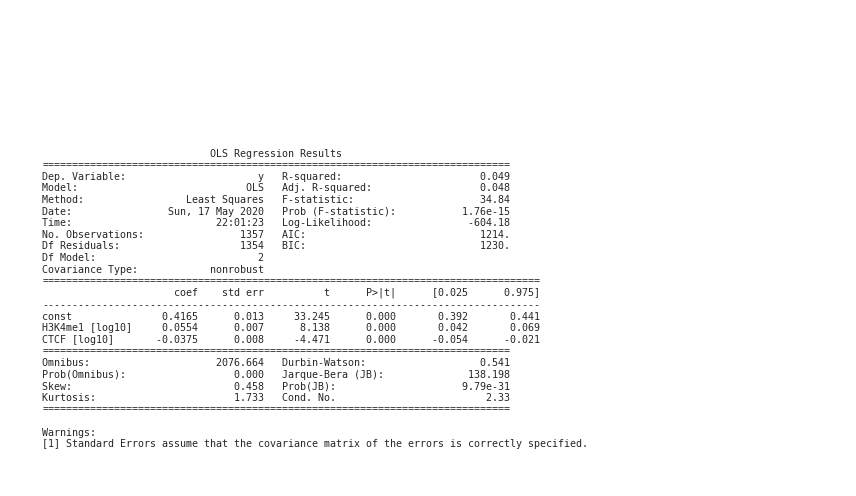

In [17]:

regressor = LinearRegression()

markCols_lab = [x+ " [log10]" for x in ['H3K4me1', 'CTCF']]

tmp_dt = keep_dt_noAll0_log10.copy()
tmp_dt.replace([np.inf, -np.inf], np.log10(logOffset), inplace=True)
my_y = tmp_dt['boundaryScore'].values.reshape(-1,1) # reshape to (1147,1) array (should be 2D)
my_x = tmp_dt[markCols_lab] # (1147,)
foo=regressor.fit(my_x, my_y) #training the algorithm

y_pred = regressor.predict(my_x)
#To retrieve the intercept:
# print('Intercept:\t%.2f' % 
regressor.intercept_
# # The coefficients
# print('Slope:\t%.2f' % 
regressor.coef_
print('Mean Absolute Error:\t%.2f' % metrics.mean_absolute_error(my_y, y_pred))
print('Mean Squared Error:\t%.2f' % metrics.mean_squared_error(my_y, y_pred))
print('Root Mean Squared Error:\t%.2f' % np.sqrt(metrics.mean_squared_error(my_y, y_pred)))
print('Coefficient of determination:\t%.2f' % metrics.r2_score(my_y, y_pred))
print("\n")

my_x2 = sm.add_constant(my_x)
multi_model = sm.OLS(my_y, my_x2).fit()
multi_model.summary()

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(multi_model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
outFile = 'multivariate4_model_summary.png'
plt.savefig(outFile)

    

In [ ]:

tmp_dt.head()
keep_dt_noAll0_log10.head()

# Other plots/analyses not used for the report

In [ ]:
# PAIRWISE CORRELATION TABLES
# pairwise correlation between all of them
# keep_dt.corr()
keep_dt_noAll0.corr()
# keep_dt_noAny0.corr()

# PAIRWISE CORRRELATION HEATMAPS
# corrs = keep_dt.corr()
# mask = np.zeros_like(corrs)
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-.4, vmax=.4)
# plt.title('Correlation matrix - all data')

corrs = keep_dt_noAll0.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-.4, vmax=.4)
plt.title('Correlation matrix - disc. all 0')
# corrs = keep_dt_noAny0.corr()
# mask = np.zeros_like(corrs)
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-.4, vmax=.4)
# plt.title('Correlation matrix - disc. any 0')

In [ ]:
# ordered_days = tips.day.value_counts().index
g = sns.FacetGrid(m_keep_dt_no0, 
                  row="variable",
                  height=2.5, 
                  aspect=2,
                  gridspec_kws={"hspace":1.1},
                  sharex=False, sharey=False)
g.map(sns.distplot, "value", hist=False, rug=True);
fontsize = 12
fontweight = 'bold'
fontproperties = {'family':'sans-serif','weight' : fontweight, 'size' : fontsize}
    
g.axes[0,0].set_xlabel('signal value', fontproperties)
g.axes[1,0].set_xlabel('signal value', fontproperties)
g.axes[2,0].set_xlabel('signal value', fontproperties)
# g.savefig('raw_data_no0_dist.png')

#     Height (in inches) of each facet. See also: aspect.
#         Aspect ratio of each facet, so that aspect * height gives the width of each facet in inches.

In [ ]:
# ordered_days = tips.day.value_counts().index
g = sns.FacetGrid(m_keep_dt_withOffset_log10, col="variable",# row_order=ordered_days,
                  height=2.5, 
                  aspect=2,
                  gridspec_kws={"hspace":1.1},
                  sharex=False, sharey=False)
g.map(sns.distplot, "value", hist=False, rug=True);
fontsize = 12
fontweight = 'bold'
fontproperties = {'family':'sans-serif','weight' : fontweight, 'size' : fontsize}
    
g.axes[0,0].set_xlabel('signal value', fontproperties)
g.axes[0,1].set_xlabel('signal value', fontproperties)
g.axes[0,2].set_xlabel('signal value', fontproperties)
# g.savefig('raw_data_offset_log10_dist.png')

#     Height (in inches) of each facet. See also: aspect.
#         Aspect ratio of each facet, so that aspect * height gives the width of each facet in inches.

In [ ]:
# ordered_days = tips.day.value_counts().index
g = sns.FacetGrid(m_keep_dt, row="variable",# row_order=ordered_days,
                  height=2.5, 
                  aspect=2,
                  gridspec_kws={"hspace":1.1},
                  sharex=False, sharey=False)
g.map(sns.distplot, "value", hist=False, rug=True);
fontsize = 12
fontweight = 'bold'
fontproperties = {'family':'sans-serif','weight' : fontweight, 'size' : fontsize}
    
g.axes[0,0].set_xlabel('signal value', fontproperties)
g.axes[1,0].set_xlabel('signal value', fontproperties)
g.axes[2,0].set_xlabel('signal value', fontproperties)
g.savefig('raw_data_all_dist.png')

#     Height (in inches) of each facet. See also: aspect.
#         Aspect ratio of each facet, so that aspect * height gives the width of each facet in inches.

In [ ]:
# Show the results of a linear regression within each dataset
sns.lmplot(x="boundaryScore", y="value", col="variable", hue="variable", data=m_keep_dt_no0_log10,
           col_wrap=3, ci=None, palette="muted", height=4, sharey=False,
           scatter_kws={"s": 50, "alpha": 1})



sns.lmplot(x="boundaryScore", y="value", col="variable", hue="variable", data=m_keep_dt_no0,
           col_wrap=3, ci=None, palette="muted", height=4, sharey=False,
           scatter_kws={"s": 50, "alpha": 1})
# => the log10 looks better !

In [ ]:
agg_dt_no0 = agg_dt[(agg_dt.T != 0).any()]
agg_dt_no0.head()
agg_dt_no0.shape